머신러닝 분석의 목표

셀럽의 데이터를 이용해 이탈확률을 예측하는 분류모델을 학습하고 그 결과를 해석하여 이탈률에 가장 큰 영향을 미치는 특징을 탐색한다.

### ML 학습을 위한 전처리

In [225]:
import pandas as pd
df_fansim=pd.read_csv('분석용_데이터_최종.csv')

In [226]:
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [227]:
df_fansim

,user_nickname,last_celeb_chat_date,first_celeb_chat_date,celeb_chat_period,celeb_chat_week,celeb_chat_count,avg_celeb_chat,last_week_celeb_chat_count,celeb_chat_length,celeb_chat_avg_len,churn,celeb_joinus_date,celeb_type,last_fan_chat_date,first_fan_chat_date,fan_chat_period,fan_chat_week,fan_chat_count,avg_fan_chat,last_week_fan_chat_count,sticker_count,Total_sticker_sales,avg_sticker_price
0,(ㅅ´ ˘ `)♡,2022-11-17,2022-11-17,1,1,7,7.00,7,57.0,8.142857,1,before 2022-09-04,churn_customer,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,BJ민하_+,2022-12-20,2022-12-20,1,1,4,4.00,4,108.0,27.000000,1,2022-12-20,churn_customer,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Chu_a,2023-01-20,2022-11-26,56,8,964,120.50,81,8481.0,8.797718,0,2022-11-26,mid_term,2023-01-20,2022-11-26,56.0,8.0,1861.0,232.62,88.0,0.0,0.0,0.0
3,Coomo,2022-09-06,2022-09-06,1,1,1,1.00,1,1.0,1.000000,1,before 2022-09-04,churn_customer,2022-11-06,2022-09-06,62.0,9.0,9.0,1.00,1.0,1.0,50.0,50.0
4,Cuha_큐하,2022-09-20,2022-09-20,1,1,2,2.00,2,55.0,27.500000,1,before 2022-09-04,churn_customer,2022-09-20,2022-09-20,1.0,1.0,1.0,1.00,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,🍓아카영,2022-11-09,2022-10-05,36,6,1643,273.83,327,22724.0,13.830797,1,before 2022-09-04,churn_customer,2022-11-09,2022-09-04,67.0,10.0,6010.0,601.00,438.0,0.0,0.0,0.0
602,🍼한우유,2023-01-20,2022-12-21,31,5,261,52.20,100,5822.0,22.306513,0,before 2022-09-04,new_customer,2023-01-20,2022-10-03,110.0,16.0,1848.0,115.50,201.0,4.0,100.0,25.0
603,👿르릉이,2023-01-20,2022-11-27,55,8,167,20.88,2,1573.0,9.419162,0,before 2022-09-04,mid_term,2023-01-20,2022-09-14,129.0,19.0,3061.0,161.11,5.0,5.0,760.0,152.0
604,🔮뉸뉴,2023-01-18,2023-01-13,6,1,83,83.00,83,615.0,7.409639,0,before 2022-09-04,new_customer,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [228]:
# ML 학습 전 데이터 누수(Data leakage) 가능성이 큰 컬럼들, 학습에 도움이 되지않는 유저닉네임 제거
df_ml= df_fansim.drop(['celeb_type','celeb_chat_period','celeb_chat_week','fan_chat_period','fan_chat_week','user_nickname'], axis=1)

#Cardinality가 너무 큰 날짜데이터들도 삭제 -> 채팅기간 컬럼으로 대체
df_ml= df_ml.drop(['last_celeb_chat_date','first_celeb_chat_date','celeb_joinus_date','last_fan_chat_date', 'first_fan_chat_date' ], axis=1)

In [229]:
#셀럽과 팬의 [최근 일주일 채팅 수 / 주 평균 채팅수] 비율 컬럼을 추가
df_ml['celeb_last_week_chat_rate'] = df_ml['last_week_celeb_chat_count'] / df_ml['avg_celeb_chat']
df_ml['fan_last_week_chat_rate'] = df_ml['last_week_fan_chat_count'] / df_ml['avg_fan_chat']

#셀럽의 주간 평균 채팅길이 컬럼을 추가  
df_ml['celeb_chat_len/week'] = df_ml['celeb_chat_avg_len'] * df_ml['avg_celeb_chat']
df_ml

,celeb_chat_count,avg_celeb_chat,last_week_celeb_chat_count,celeb_chat_length,celeb_chat_avg_len,churn,fan_chat_count,avg_fan_chat,last_week_fan_chat_count,sticker_count,Total_sticker_sales,avg_sticker_price,celeb_last_week_chat_rate,fan_last_week_chat_rate,celeb_chat_len/week
0,7,7.00,7,57.0,8.142857,1,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,NaN,57.000000
1,4,4.00,4,108.0,27.000000,1,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,NaN,108.000000
2,964,120.50,81,8481.0,8.797718,0,1861.0,232.62,88.0,0.0,0.0,0.0,0.672199,0.378299,1060.125000
3,1,1.00,1,1.0,1.000000,1,9.0,1.00,1.0,1.0,50.0,50.0,1.000000,1.000000,1.000000
4,2,2.00,2,55.0,27.500000,1,1.0,1.00,1.0,0.0,0.0,0.0,1.000000,1.000000,55.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,1643,273.83,327,22724.0,13.830797,1,6010.0,601.00,438.0,0.0,0.0,0.0,1.194172,0.728785,3787.287231
602,261,52.20,100,5822.0,22.306513,0,1848.0,115.50,201.0,4.0,100.0,25.0,1.915709,1.740260,1164.400000
603,167,20.88,2,1573.0,9.419162,0,3061.0,161.11,5.0,5.0,760.0,152.0,0.095785,0.031035,196.672096
604,83,83.00,83,615.0,7.409639,0,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,NaN,615.000000


총 14개의 특징과 1개의 타겟으로 구성된 데이터프레임

In [230]:
#결측치 확인
df_ml.isna().sum()

celeb_chat_count                0
avg_celeb_chat                  0
last_week_celeb_chat_count      0
celeb_chat_length               0
celeb_chat_avg_len              0
churn                           0
fan_chat_count                  0
avg_fan_chat                    0
last_week_fan_chat_count        0
sticker_count                   0
Total_sticker_sales             0
avg_sticker_price               0
celeb_last_week_chat_rate       0
fan_last_week_chat_rate       136
celeb_chat_len/week             0
dtype: int64

In [231]:
# 팬 채팅기록이 없으므로 0으로 결측값 대치
df_ml = df_ml.fillna(0)

In [232]:
# 데이터의 크기가 작으므로, 따로 학습세트, 검증세트를 나누지 않고 모든데이터를 이용해 학습한다
# 타겟과 데이터 분리
target = 'churn'

X, y = df_ml.drop(columns=target), df_fansim[target]

In [233]:
# 타겟 분포 확인
y.value_counts()

1    381
0    225
Name: churn, dtype: int64

### 모델 학습

타겟이 0/1로 분류되어있으므로 분류모델을 학습하여 모델을 해석한다.

타겟의 분포가 6:4정도로 적당한 균형을 보이고 있으므로 정확도(accuracy)를 주요 지표로 사용한다.

In [234]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

def eval_models(y_pred, y_pred_proba, y_real=y) :
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y, y_pred_proba)

    print(f'accuracy : {accuracy.round(2)}')
    print(f'precision : {precision.round(2)}')
    print(f'recall : {recall.round(2)}')
    print(f'f1 : {f1.round(2)}')
    print(f"auc score : {auc.round(3)}")

    return accuracy, precision, recall, f1, auc

baseline 모델

In [235]:
from sklearn.metrics import accuracy_score
base = y.mode()[0]
baseline = len(y) * [base]

eval_models(baseline,baseline)

accuracy : 0.63
precision : 0.63
recall : 1.0
f1 : 0.77
auc score : 0.5


(0.6287128712871287, 0.6287128712871287, 1.0, 0.7720364741641337, 0.5)

로지스틱 회귀

In [236]:
#로지스틱 회귀
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Cs = np.power(10.0, np.arange(-10, 10))

lr_model = LogisticRegressionCV(Cs=Cs, cv=5, max_iter=1000, scoring="accuracy", random_state=42)
lr_model.fit(X_scaled, y)

LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09]),
                     cv=5, max_iter=1000, random_state=42, scoring='accuracy')

In [237]:
y_pred_lr = lr_model.predict(X_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_scaled)[:,1]
eval_models(y_pred_lr,y_pred_proba_lr)

accuracy : 0.78
precision : 0.76
recall : 0.96
f1 : 0.85
auc score : 0.815


(0.7805280528052805,
 0.7583333333333333,
 0.9553805774278216,
 0.845528455284553,
 0.8154155730533684)

랜덤 포레스트

In [238]:
params = {'max_depth': np.arange(3, 15, 2),
               'min_samples_split': [2, 4, 8, 16],
               'min_samples_leaf': [1, 2, 4]
               }

In [239]:
#랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model  = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_model, param_distributions = params, scoring="accuracy", n_iter = 10, cv = 5, verbose=3, random_state=42)
rf_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.861 total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.793 total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.760 total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.818 total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.760 total time=   0.1s
[CV 1/5] END max_depth=13, min_samples_leaf=1, min_samples_split=8;, score=0.852 total time=   0.1s
[CV 2/5] END max_depth=13, min_samples_leaf=1, min_samples_split=8;, score=0.802 total time=   0.1s
[CV 3/5] END max_depth=13, min_samples_leaf=1, min_samples_split=8;, score=0.777 total time=   0.1s
[CV 4/5] END max_depth=13, min_samples_leaf=1, min_samples_split=8;, score=0.818 total time=   0.1s
[CV 5/5] END max_depth=13, min_samples_leaf=

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 8, 16]},
                   random_state=42, scoring='accuracy', verbose=3)

In [240]:
rf_search.best_params_

{'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 7}

In [241]:
y_pred_rf = rf_search.best_estimator_.predict(X)
y_pred_proba_rf = rf_search.best_estimator_.predict_proba(X)[:,1]
eval_models(y_pred_rf,y_pred_proba_rf)

accuracy : 0.9
precision : 0.9
recall : 0.96
f1 : 0.93
auc score : 0.966


(0.9026402640264026,
 0.896551724137931,
 0.9553805774278216,
 0.9250317662007626,
 0.9655001458151065)

xgb

In [242]:
params = {
    "max_depth": np.arange(3, 17, 2),
    "min_child_weight": [2, 4, 8, 16],
    "n_estimators" : np.arange(100, 800, 100),
    "learning_rate" : np.arange(0.05, 0.2, 0.05)
}

In [243]:
#xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            random_state=42,
            learning_rate=0.1,
            n_jobs=-1,
            )

xgb_search = RandomizedSearchCV(xgb_model, param_distributions = params, scoring="accuracy", n_iter = 10, cv = 5, verbose=1, random_state=42)
xgb_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13, 15]),
                                        'min_child_weight': [2, 4, 8, 16],
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700])},
                   random_state=42, scoring='accuracy', verbose=1)

In [244]:
xgb_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 0.1}

In [245]:
y_pred_xgb = xgb_search.best_estimator_.predict(X)
y_pred_proba_xgb = xgb_search.best_estimator_.predict_proba(X)[:,1]
eval_models(y_pred_xgb,y_pred_proba_xgb)

accuracy : 0.97
precision : 0.96
recall : 0.98
f1 : 0.97
auc score : 0.993


(0.966996699669967,
 0.9640102827763496,
 0.984251968503937,
 0.974025974025974,
 0.992901720618256)

lgbm

In [246]:
params = {
    "max_depth": np.arange(3, 17, 2),
    "min_child_weight": [2, 4, 8, 16],
    "n_estimators" : np.arange(100, 800, 100),
    "learning_rate" : np.arange(0.05, 0.2, 0.05)
}

In [247]:
from lightgbm import LGBMClassifier
lgbm_model= LGBMClassifier(random_state=42,
                       learning_rate=0.1,                         
                               n_jobs=-1)

lgbm_search = RandomizedSearchCV(lgbm_model, param_distributions = params, scoring="accuracy", n_iter = 10, cv = 5, verbose=1, random_state=42)
lgbm_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13, 15]),
                                        'min_child_weight': [2, 4, 8, 16],
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700])},
                   random_state=42, scoring='accuracy', verbose=1)

In [248]:
lgbm_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 0.1}

In [249]:
y_pred_lgbm = lgbm_search.best_estimator_.predict(X)
y_pred_proba_lgbm = lgbm_search.best_estimator_.predict_proba(X)[:,1]
eval_models(y_pred_xgb,y_pred_proba_xgb)

accuracy : 0.97
precision : 0.96
recall : 0.98
f1 : 0.97
auc score : 0.993


(0.966996699669967,
 0.9640102827763496,
 0.984251968503937,
 0.974025974025974,
 0.992901720618256)

모델 비교

In [250]:
comparison_metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'auc'], columns=['Base','Logistic', 'Randomforest', 'LGBM', 'XGBoost'])
comparison_metrics['Base'] = eval_models(baseline,baseline)
comparison_metrics['Logistic'] =eval_models(y_pred_lr,y_pred_proba_lr)
comparison_metrics['Randomforest'] =eval_models(y_pred_rf,y_pred_proba_rf)
comparison_metrics['LGBM'] =eval_models(y_pred_lgbm,y_pred_proba_lgbm)
comparison_metrics['XGBoost'] =eval_models(y_pred_xgb,y_pred_proba_xgb)
comparison_metrics.round(3)

accuracy : 0.63
precision : 0.63
recall : 1.0
f1 : 0.77
auc score : 0.5
accuracy : 0.78
precision : 0.76
recall : 0.96
f1 : 0.85
auc score : 0.815
accuracy : 0.9
precision : 0.9
recall : 0.96
f1 : 0.93
auc score : 0.966
accuracy : 0.97
precision : 0.96
recall : 0.99
f1 : 0.98
auc score : 0.994
accuracy : 0.97
precision : 0.96
recall : 0.98
f1 : 0.97
auc score : 0.993


,Base,Logistic,Randomforest,LGBM,XGBoost
accuracy,0.629,0.781,0.903,0.970,0.967
precision,0.629,0.758,0.897,0.964,0.964
recall,1.000,0.955,0.955,0.990,0.984
f1,0.772,0.846,0.925,0.977,0.974
auc,0.500,0.815,0.966,0.994,0.993


지표가 가장 좋은 XGBoost모델을 선택

### 이탈 확률 확인

In [258]:
df_fansim['churn_proba'] =  y_pred_proba_lgbm

In [260]:
df_fansim.to_csv('cp2_ML_proba.csv', index=False)

In [261]:
#잔존 고객의 이탈확률을 확인
df_proba = df_fansim[df_fansim['churn']==0][['user_nickname','churn_proba']].sort_values(ascending=False,by='churn_proba').reset_index(drop=True)
df_proba

,user_nickname,churn_proba
0,구독,0.938028
1,가가가가가가가가가가가가가가가가가가가가,0.921040
2,백오105105,0.795766
3,아봉둥이,0.770558
4,사뚜,0.692443
...,...,...
220,왕군,0.002479
221,윰로로,0.002315
222,겨우디,0.002265
223,유은_,0.002055


In [262]:
df_proba.to_csv('cp2_ML_분석결과.csv', index=False)

ML 예측확률 분석

In [265]:
#고객 타입별
df_fansim.groupby('celeb_type').mean()['churn_proba']

C:\Users\elyse\AppData\Local\Temp\ipykernel_23336\2278493892.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_fansim.groupby('celeb_type').mean()['churn_proba']


celeb_type
churn_customer    0.908885
long_term         0.082179
mid_term          0.146424
new_customer      0.324596
Name: churn_proba, dtype: float64

C:\Users\elyse\AppData\Local\Temp\ipykernel_23336\3786383368.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_fansim.groupby('celeb_type').mean()['churn_proba'].drop('churn_customer').plot.bar()


<AxesSubplot: xlabel='celeb_type'>

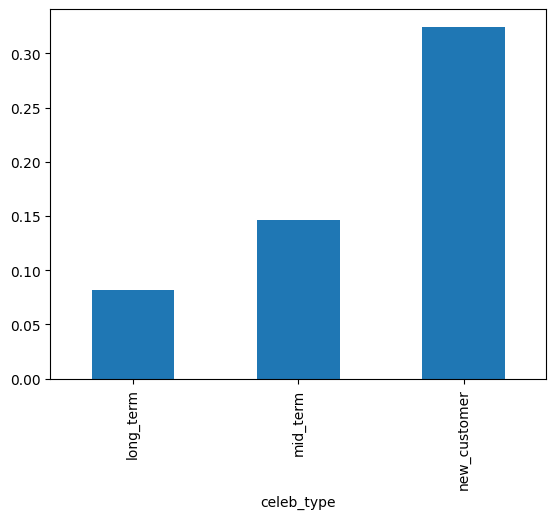

In [266]:
df_fansim.groupby('celeb_type').mean()['churn_proba'].drop('churn_customer').plot.bar()

### 특성중요도 확인

<AxesSubplot: >

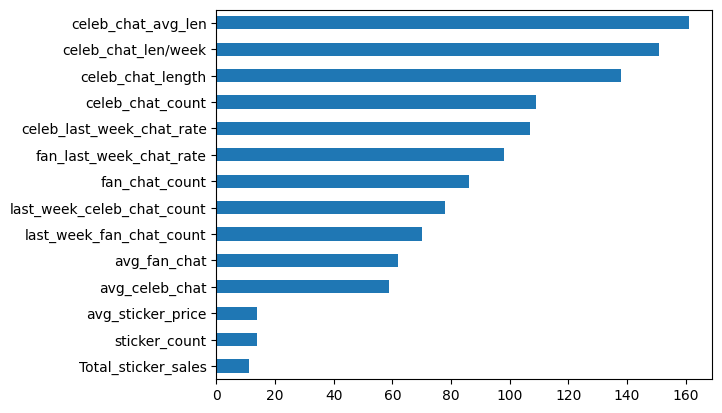

In [267]:
import matplotlib.pyplot as plt
importances  = pd.Series(lgbm_search.best_estimator_.feature_importances_, X.columns)

importances.sort_values().plot.barh()

In [268]:
df_fansim.groupby('churn').mean()['last_week_fan_chat_count']

C:\Users\elyse\AppData\Local\Temp\ipykernel_23336\260007206.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_fansim.groupby('churn').mean()['last_week_fan_chat_count']


churn
0    168.395556
1     21.146982
Name: last_week_fan_chat_count, dtype: float64

In [270]:
df_tmp = df_fansim.copy()
df_tmp['celeb_chat_len/week'] = df_tmp['celeb_chat_avg_len'] * df_tmp['avg_celeb_chat']
df_tmp.groupby('churn').mean()['celeb_chat_len/week']

C:\Users\elyse\AppData\Local\Temp\ipykernel_23336\397827665.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp.groupby('churn').mean()['celeb_chat_len/week']


churn
0    1998.169353
1     796.218513
Name: celeb_chat_len/week, dtype: float64

순열중요도 확인

In [278]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    lgbm_search.best_estimator_,
    scoring="accuracy",  
    n_iter=10,
    random_state=42,
)

permuter.fit(X,y)

feature_names = X.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,  
    feature_names=feature_names
)


Weight,Feature
0.1691 ± 0.0318,celeb_chat_length
0.1416 ± 0.0108,last_week_fan_chat_count
0.0650 ± 0.0142,fan_last_week_chat_rate
0.0441 ± 0.0105,celeb_chat_count
0.0408 ± 0.0135,celeb_chat_len/week
0.0309 ± 0.0090,avg_fan_chat
0.0307 ± 0.0113,celeb_last_week_chat_rate
0.0304 ± 0.0127,fan_chat_count
0.0279 ± 0.0076,celeb_chat_avg_len
0.0170 ± 0.0072,last_week_celeb_chat_count
